In [1]:
import numpy as np
import h5py
import ppsci
import paddle
from paddle.io.dataloader import BatchSampler

from ppsci.utils import logger
from matplotlib import pyplot as plt

from TopOptModel import TopOptNN
from data_utils import NewNamedArrayDataset, augmentation, batch_transform_wrapper

In [2]:
ppsci.utils.set_random_seed(42)
BATCH_SIZE = 64
N_SAMPLE = 10000
OUTPUT_DIR = "./Outputs/results"
logger.init_logger("ppsci", f"{OUTPUT_DIR}/results.log", "info")

In [3]:
data_path = "./Dataset/PreparedData/top_dataset.h5"
sampler = lambda: np.random.randint(1, 99)
h5data = h5py.File(data_path, 'r')
X = h5data['iters']
Y = h5data['targets']
X_data = []
Y_data = []
for i in range(N_SAMPLE):
    X_data.append(np.array(X[i]))
    Y_data.append(np.array(Y[i]))
dataset = NewNamedArrayDataset({'input': X_data}, {'output': Y_data}, transforms = augmentation)

In [4]:
iterations = range(5, 85, 5)
model = TopOptNN()

In [5]:
def metric_expr(output_dict, label_dict, weight_dict = None):
    output = output_dict["output"]
    y = label_dict["output"]
    accurates = paddle.equal(paddle.round(y), paddle.round(output))
    acc = paddle.mean(paddle.cast(accurates, dtype='float32'))
    w00 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 0.), paddle.equal(paddle.round(y), 0.))), dtype="float32")
    w11 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 1.), paddle.equal(paddle.round(y), 1.))), dtype="float32")
    w01 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 1.), paddle.equal(paddle.round(y), 0.))), dtype="float32")
    w10 = paddle.cast(paddle.sum(paddle.multiply(paddle.equal(paddle.round(output), 0.), paddle.equal(paddle.round(y), 1.))), dtype="float32")
    n0 = paddle.add(w01, w00)
    n1 = paddle.add(w11, w10)
    iou = 0.5 * paddle.add(
        paddle.divide(w00, paddle.add(n0, w10)),
        paddle.divide(w11, paddle.add(n1, w01))
    )
    return {
        "Binary_Acc": acc,
        "IoU": iou
    }

In [6]:
num_val_step = 10
acc_results_summary = {}
iou_results_summary = {}
model_list = ['Poisson5', 'Poisson10', 'Poisson30', 'Uniform']
for model_name in model_list:
    solver = ppsci.solver.Solver(
        model,
        pretrained_model_path= "./Outputs/"+ model_name +"_vol_coeff1/checkpoints/latest"
    )
    acc_results = []
    iou_results = []
    for stop_iter in iterations:
        data_loader = paddle.io.DataLoader(
            dataset=dataset,
            batch_sampler=BatchSampler(dataset=dataset,sampler=None,shuffle=True,batch_size=BATCH_SIZE,drop_last=False),
            collate_fn=batch_transform_wrapper(lambda: stop_iter),
        )
        total_val_steps = 0
        current_acc_results = []
        current_iou_results = []

        for x, y, _ in iter(data_loader):
            if total_val_steps >= num_val_step:
                break
            out = solver.predict(x, batch_size=64)
            metric = metric_expr(out, y)
            current_acc_results.append(np.array(metric['Binary_Acc']))
            current_iou_results.append(np.array(metric['IoU']))
            total_val_steps += 1

        acc_results.append(np.mean(current_acc_results))
        iou_results.append(np.mean(current_iou_results))
    
    acc_results_summary[model_name] = acc_results
    iou_results_summary[model_name] = iou_results

[2023/10/05 17:41:23] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Poisson5_vol_coeff1/checkpoints/latest
[2023/10/05 17:41:23] ppsci INFO: Using paddlepaddle develop(345de9a) on device Place(gpu:0)
[2023/10/05 17:41:23] ppsci INFO: Set to_static=False for forward computation.
[2023/10/05 17:41:37] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Poisson10_vol_coeff1/checkpoints/latest
[2023/10/05 17:41:37] ppsci INFO: Using paddlepaddle develop(345de9a) on device Place(gpu:0)
[2023/10/05 17:41:37] ppsci INFO: Set to_static=False for forward computation.
[2023/10/05 17:41:47] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Poisson30_vol_coeff1/checkpoints/latest
[2023/10/05 17:41:47] ppsci INFO: Using paddlepaddle develop(345de9a) on device Place(gpu:0)
[2023/10/05 17:41:47] ppsci INFO: Set to_static=False for forward computation.
[2023/10/05 17:41:57] ppsci MESSAGE: Finish loading pretrained model from ./Outputs/Uniform_vol_coeff1/checkpoint

In [7]:
th_acc_results = []
th_iou_results = []
for stop_iter in iterations:
    data_loader = paddle.io.DataLoader(
        dataset=dataset,
        batch_sampler=BatchSampler(dataset=dataset,sampler=None,shuffle=True,batch_size=BATCH_SIZE,drop_last=False),
        collate_fn=batch_transform_wrapper(lambda: stop_iter),
    )
    total_val_steps = 0
    current_acc_results = []
    current_iou_results = []

    for x, y, _ in iter(data_loader):
        if total_val_steps >= num_val_step:
            break

        # thresholding
        out = paddle.cast(x['input'][:,0:1,:,:] > 0.5, dtype="float32")
        metric = metric_expr({'output': out}, y)
        current_acc_results.append(np.array(metric['Binary_Acc']))
        current_iou_results.append(np.array(metric['IoU']))
        total_val_steps += 1

    th_acc_results.append(np.mean(current_acc_results))
    th_iou_results.append(np.mean(current_iou_results))
    
acc_results_summary['thresholding'] = th_acc_results
iou_results_summary['thresholding'] = th_iou_results

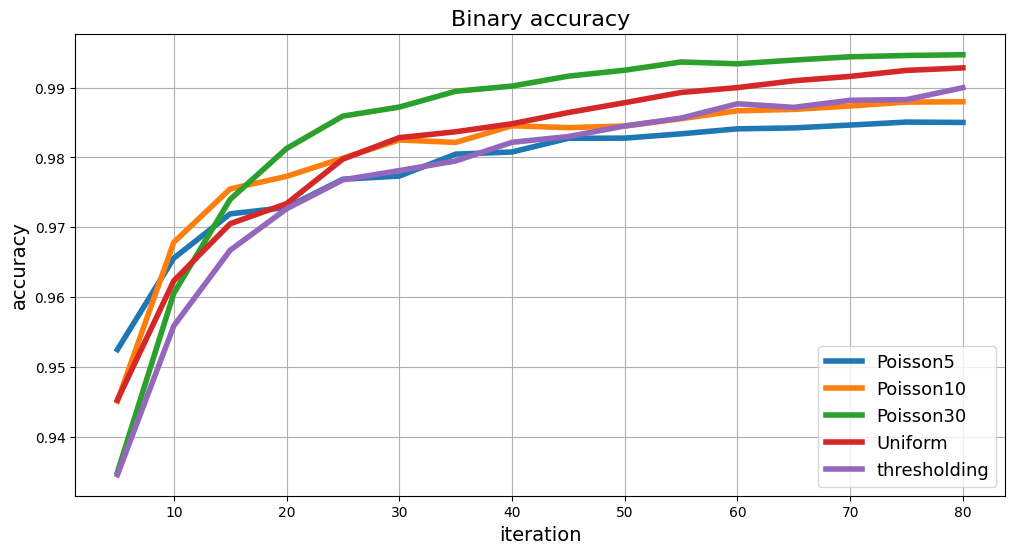

In [8]:
plt.figure(figsize=(12, 6))

for k, v in acc_results_summary.items():
    plt.plot(iterations, v, label=k, lw=4)
    
plt.title('Binary accuracy', fontsize=16)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.show()

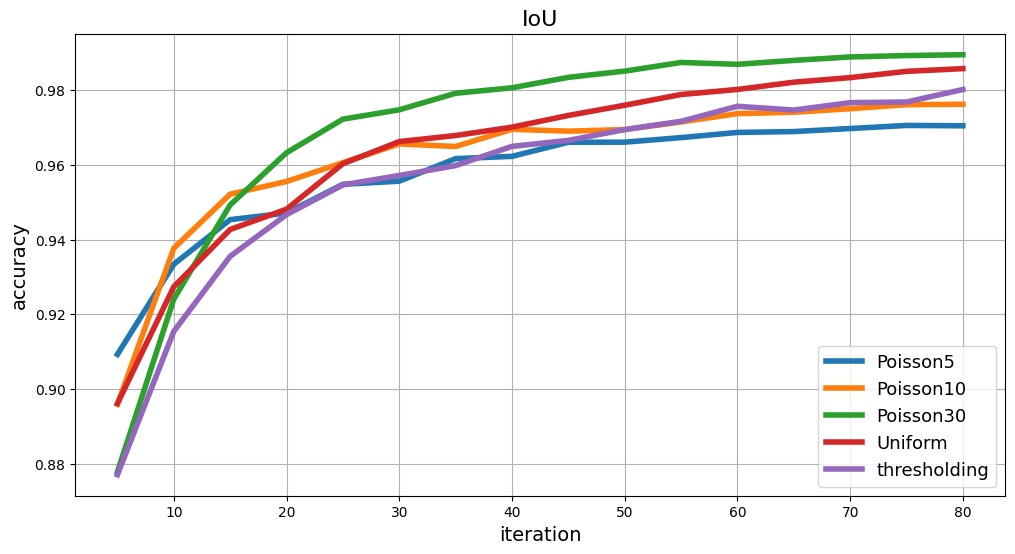

In [9]:
plt.figure(figsize=(12, 6))

for k, v in iou_results_summary.items():
    plt.plot(iterations, v, label=k, lw=4)
    
plt.title('IoU', fontsize=16)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.show()

In [10]:
 # the paper only reported interation = 5, 10, 15, 20, 30, 40, 50, 60, 80
paper_acc_result = {'Poisson5':[95.8, 97.3, 97.7, 97.9, 98.2, 98.4, 98.5, 98.6, 98.7],
                'Poisson10':[95.4, 97.6, 98.1, 98.4, 98.7, 98.9, 99.0, 99.0, 99.0],
                'Poisson30':[92.7, 96.3, 97.8, 98.5, 99.0, 99.2, 99.4, 99.5, 99.6],
                'Uniform':[94.7, 96.8, 97.7, 98.2, 98.7, 99.0, 99.3, 99.4, 99.6],
                'thresholding': [92.9, 95.4, 96.5, 97.1, 97.7, 98.1, 98.4, 98.6, 98.9]}
paper_iou_result = {'Poisson5':[92.0, 94.7, 95.4, 96.0, 96.5, 96.9, 97.1, 97.3, 97.4],
                'Poisson10':[91.1, 95.3, 96.4, 96.9, 97.4, 97.8, 98.0, 98.0, 98.1],
                'Poisson30':[86.4, 92.9, 95.7, 97.0, 98.1, 98.5, 98.8, 99.0, 99.2],
                'Uniform':[90.0, 93.9, 95.5, 96.4, 97.5, 98.1, 98.6, 98.8, 99.2],
                'thresholding': [86.8, 91.2, 93.3, 94.3, 95.6, 96.3, 96.8, 97.3, 97.9]}

In [11]:
reported_idx = [0,1,2,3,5,7,9,11,15]

In [18]:
# error
for k in acc_results_summary.keys():
    print(k+": Acc_error_rate: ")
    print(np.round(np.abs(np.array(acc_results_summary[k])[reported_idx] - np.array(paper_acc_result[k])/100)/(np.array(paper_acc_result[k])/100), 4))
for k in iou_results_summary.keys():
    print(k+": IoU_error_rate: ")
    print(np.round(np.abs(np.array(iou_results_summary[k])[reported_idx] - np.array(paper_iou_result[k])/100)/(np.array(paper_iou_result[k])/100), 4))

Poisson5: Acc_error_rate: 
[0.0058 0.0076 0.0052 0.0063 0.0048 0.0033 0.0023 0.0019 0.002 ]
Poisson10: Acc_error_rate: 
[0.0093 0.0084 0.0056 0.0068 0.0046 0.0045 0.0056 0.0034 0.0021]
Poisson30: Acc_error_rate: 
[0.0085 0.0026 0.0041 0.0038 0.0028 0.0018 0.0015 0.0016 0.0013]
Uniform: Acc_error_rate: 
[0.0018 0.0059 0.0067 0.0088 0.0042 0.0052 0.0052 0.004  0.0032]
thresholding: Acc_error_rate: 
[0.006  0.002  0.0018 0.0017 0.0011 0.0012 0.0005 0.0017 0.001 ]
Poisson5: IoU_error_rate: 
[0.0117 0.0144 0.0091 0.0135 0.0097 0.007  0.0051 0.0045 0.0037]
Poisson10: IoU_error_rate: 
[0.0166 0.0161 0.0123 0.0139 0.0086 0.0087 0.0108 0.0064 0.0049]
Poisson30: IoU_error_rate: 
[0.016  0.0053 0.0081 0.007  0.0064 0.0045 0.003  0.0031 0.0026]
Uniform: IoU_error_rate: 
[0.0044 0.0124 0.0129 0.0165 0.009  0.0111 0.0102 0.0079 0.0063]
thresholding: IoU_error_rate: 
[0.0104 0.0037 0.0027 0.0039 0.0012 0.002  0.0015 0.0027 0.0012]
